# __Part A: Convolutional Neural Network__

<a class="anchor" id="1"></a>
## <font color='#71a1e3'> __Previously__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

1. 128 x 128 Baseline Model was done
2. Vgg_Model, CNN model 1 and CNN model 2 was decided as the best 3 models

<a class="anchor" id="3"></a>
## <font color='#71a1e3'>__Import Libraries__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import all the necessary libraries

In [1]:
# !unzip 1.zip

In [2]:
%pip install tensorflow_addons keras-tuner pandas matplotlib seaborn scikit-learn tqdm efficientnet numba 

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# !sudo nvidia-smi --gpu-reset -i 0

### Other Imports

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix, cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.metrics import classification_report, accuracy_score

import os, time, math, datetime, warnings, pytz, glob
from IPython.display import display
from functools import reduce
import absl.logging
from tqdm import tqdm
import logging
from efficientnet.tfkeras import EfficientNetB3

absl.logging.set_verbosity(absl.logging.ERROR)
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings('ignore')

### Tensorflow Import

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow import expand_dims
from tensorflow.keras import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.image import random_flip_left_right, random_crop, resize_with_crop_or_pad
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Dense, Input, InputLayer, Normalization, Flatten,BatchNormalization,
    Dropout,Conv2D, GlobalAveragePooling2D, MaxPooling2D, ReLU, Layer,Activation, Multiply, AveragePooling2D,
    Add, RandomRotation,Resizing, Rescaling, Reshape, Concatenate, concatenate, Lambda,LeakyReLU, ZeroPadding2D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN, TensorBoard, CSVLogger, Callback
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adagrad, Adamax
from tensorflow.keras.regularizers import l2, L2
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.metrics import FalseNegatives, categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import *
from tensorflow_addons.optimizers import SWA
from tensorflow.keras import layers

from kerastuner.tuners import Hyperband
from kerastuner import RandomSearch
from kerastuner import HyperModel
# Setting a seaborn style
sns.set(style="whitegrid")


### Set the seed of this notebook

In [6]:
seed = 32
tf.random.set_seed(seed)
np.random.seed(seed)

<a class="anchor" id="3"></a>
## <font color='#71a1e3'>__Check for GPU__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is check the available GPUs and set the memory growth

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


In [8]:
!nvidia-smi

Sun Nov 26 16:01:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:03:00.0 Off |                  Off |
|  0%   35C    P2              51W / 450W |   5471MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Import dataset__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to import the dataset and proceed to do analysis on it

### 128 x 128 Images

In [9]:
data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/train'  ,
                                                   color_mode='rgb',
                                                   image_size=(128,128))
data_big

Found 9028 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

#### Train Data

In [10]:
X_train_big = []
y_train_big = []

for images, labels in tqdm(data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_train_big.append(images)
    y_train_big.append(labels)

X_train_big = np.concatenate(X_train_big, axis=0)
X_train_big = np.squeeze(X_train_big, axis=-1)
y_train_big = np.concatenate(y_train_big, axis=0)

100%|██████████| 283/283 [00:02<00:00, 116.51it/s]


#### Validation Data

In [11]:
val_data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/validation'  ,
                                                   color_mode='rgb',
                                                   image_size=(128,128))
val_data_big

Found 3000 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
X_val_big = []
y_val_big = []

for images, labels in tqdm(val_data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_val_big.append(images)
    y_val_big.append(labels)

X_val_big = np.concatenate(X_val_big, axis=0)
X_val_big = np.squeeze(X_val_big, axis=-1)
y_val_big = np.concatenate(y_val_big, axis=0)

100%|██████████| 94/94 [00:00<00:00, 170.01it/s]


#### Test Data

In [13]:
test_data_big = tf.keras.utils.image_dataset_from_directory('Dataset for CA1 part A/test'  ,
                                                   color_mode='rgb',
                                                   image_size=(128,128))
test_data_big

Found 3000 files belonging to 15 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
X_test_big = []
y_test_big = []

for images, labels in tqdm(test_data_big):
    images = tf.image.rgb_to_grayscale(images)
    X_test_big.append(images)
    y_test_big.append(labels)

X_test_big = np.concatenate(X_test_big, axis=0)
X_test_big = np.squeeze(X_test_big, axis=-1)
y_test_big = np.concatenate(y_test_big, axis=0)

100%|██████████| 94/94 [00:00<00:00, 167.22it/s]


In [15]:
labels_dict = os.listdir('Dataset for CA1 part A/train')
labels_dict = {idx: label for idx, label in enumerate(labels_dict)}
print(labels_dict)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


<a class="anchor" id="4"></a>
## <font color='#71a1e3'>__Required Functions__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

Here is to define all the required functions

In [16]:
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
val_split = 0.2
max_epochs = 100


In [17]:
y_train_big = to_categorical(y_train_big)
y_val_big = to_categorical(y_val_big)

### VGG 16 Model

In [18]:
def vgg_conv_layer(filters, kernel_size=3, activation='relu', weight_decay=WEIGHT_DECAY):
    return Sequential([
        Conv2D(filters, kernel_size, padding='same', activation=None, kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        ReLU() if activation == 'relu' else activation
    ])

def vgg_conv_block(no_layers, filters, activation='relu'):
    block = Sequential()
    for _ in range(no_layers):
        block.add(vgg_conv_layer(filters, activation=activation))
    block.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    return block

class VGGNet(Model):
    def __init__(self, input_shape, num_classes, name='VGGNet_Baseline'):
        super(VGGNet, self).__init__(name=name)
        self.vgg_blocks = [
            vgg_conv_block(2, 32, activation='relu'),
            vgg_conv_block(3, 64, activation='relu'),
            vgg_conv_block(3, 128, activation='relu'),
            vgg_conv_block(3, 256, activation='relu'),
        ]
        self.global_pool = GlobalAveragePooling2D()
        self.classifier = Sequential([
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

    def call(self, inputs):
        x = inputs
        for block in self.vgg_blocks:
            x = block(x)
        x = self.global_pool(x)
        return self.classifier(x)

    def build(self, input_shape):
        inputs = Input(shape=(128,128,1))
        model = Model(inputs=inputs, outputs=self.call(inputs), name=self.name)
        return model
input_shape = (128, 128, 1)
num_classes = 15
vgg = VGGNet(input_shape, num_classes)
vgg_model = vgg.build(input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### CNN Baseline 2

In [19]:
def CNN2(name='CNN2_Baseline'):

    filters_list = [32, 64, 128, 128, 128, 128]

    model = Sequential()

    # Add initial convolutional layers
    model.add(Conv2D(filters=filters_list[0], kernel_size=(3, 3), padding='same', input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(filters=filters_list[1], kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    for filters in filters_list[2:]:
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(15, activation='softmax')) 

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


In [20]:
no = lambda x : x
def data_before_train(self, aug_func=no):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_big, y_train_big)).map(lambda x, y : (expand_dims(x, -1), y))
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_big, y_val_big)).shuffle(128 * 100).batch(128).map(lambda x, y : (expand_dims(x, -1), y)).prefetch(tf.data.AUTOTUNE)
    train_ds = train_ds.map(lambda x, y : (aug_func(x), y), num_parallel_calls=tf.data.AUTOTUNE).shuffle(128 * 100).batch(128).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds
train_ds, val_ds = data_before_train(no)

In [21]:
def evaluation_test(model, X_val, y_val, LABELS):
    final_predictions = model.predict(X_val)
    final_predictions_final = np.argmax(final_predictions, axis=1)
    y_test_final = np.argmax(y_val, axis=1) if y_val.ndim == 2 else y_val
    classification_results = classification_report(y_test_final, final_predictions_final, target_names=LABELS.values(), output_dict=True)

    print('Accuracy:', accuracy_score(y_test_final, final_predictions_final))
    result = pd.DataFrame(classification_results).transpose().sort_values('f1-score')
    return result


In [22]:
def plot_classification_heatmap(df):
    heatmap_data = df.drop(['accuracy', 'macro avg', 'weighted avg']).iloc[:, :-1]
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="Blues")
    plt.title("Classification Report Heatmap")
    plt.show()


In [23]:
class Evaluator:
  def __init__(self, path=None, project_name="CNN_CA1"):
      # Initialize wandb
      self.project_name = project_name

      # Your existing initialization code
      if path:
          self.result = pd.read_csv(path, sep=';')
      else:
          cols = ['Model Name', 'Batch Size', "Train Loss", "Test Loss", "Train Acc", "Test Acc", "Remarks"]
          self.result = pd.DataFrame(columns=cols)

      self.callback = [
          TerminateOnNaN()
      ]
      # self.api = wandb.Api()

  def train_model(self, model, train, val, hyperparameters, callbacks):
    tf.keras.backend.clear_session()
    epochs = hyperparameters['max_epochs']
    batch_size = 64

    if val is None:
      X_train, y_train = train
      return model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split = hyperparameters["val_split"], callbacks=callbacks).history
    else:
      return model.fit(train, validation_data = val, epochs = epochs, batch_size = batch_size , callbacks=callbacks).history

  def model_evaluate(self, train, val, model, hyperparameters, callbacks=None, plot_loss=True, remarks=""):
      tf.keras.backend.clear_session()
      # wandb.init(project=self.project_name)
      callbacks = (callbacks or [EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5)]) + self.callback
      history = self.train_model(model, train, val, hyperparameters, callbacks)
      bestval_index = np.argmax(history['val_accuracy'])


      if plot_loss:
          try:
              fig = plot_model_history(history)
          except Exception as e:
              print(e, 'here')
              print("error creating loss curve")
              fig = None

      result = {
          "Model Name": model.name,
          "Epochs": len(history["loss"]),
          "Batch Size": hyperparameters["batch_size"],
          "Train Loss": history["loss"][bestval_index],
          "Test Loss": history["val_loss"][bestval_index],
          "Train Acc": history["accuracy"][bestval_index],
          "Test Acc": history["val_accuracy"][bestval_index]
      }
      # wandb.log({
      #     "Model Name": model.name,
      #     "Epochs": len(history["loss"]),
      #     "Batch Size": hyperparameters["batch_size"],
      #     "Train Loss": history["loss"][bestval_index],
      #     "Test Loss": history["val_loss"][bestval_index],
      #     "Train Acc": history["accuracy"][bestval_index],
      #     "Test Acc": history["val_accuracy"][bestval_index],
      # })

      # wandb.finish()
      return result, fig

  def _train_model(self, model, training_data, validation_data, hyperparameters, callbacks):
      tf.keras.backend.clear_session()
      epochs = hyperparameters["max_epochs"]
      batch_size = hyperparameters["batch_size"]

      if validation_data is None:
          X_train, y_train = training_data
          return model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=hyperparameters["val_split"], callbacks=callbacks).history

      return model.fit(training_data, validation_data=validation_data, epochs=epochs, batch_size=batch_size, callbacks=callbacks).history


  def return_history(self, project_name='CNN_CA1', entity=None, include_cols=None):
      if include_cols is None:
          include_cols = ['Model Name', 'Epochs', 'Batch Size', 'Train Loss','Test Loss','Train Acc','Test Acc','Remarks']

      runs = self.api.runs('111da/CNN_CA1')
      # List to store results
      results = []

      for run in runs:
          run_summary = run.summary
          data = {}
          for col in include_cols:
              data[col] = run_summary.get(col, None)
          results.append(data)
      df = pd.DataFrame(results)

      return df


  def remove_model(self, model_name):
      self.result = self.result[self.result["Model Name"] != model_name]


In [24]:
def plot_model_history(model_history):
    history_df = pd.DataFrame(model_history)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(history_df['loss'], 'g--', label='Training Loss')
    axs[0].plot(history_df['val_loss'], 'b-', label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    if 'accuracy' in history_df and 'val_accuracy' in history_df:
        axs[1].plot(history_df['accuracy'], 'g--', label='Training Accuracy')
        axs[1].plot(history_df['val_accuracy'], 'b-', label='Validation Accuracy')
        axs[1].set_title('Training and Validation Accuracy')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        axs[1].grid(True)

    plt.tight_layout()
    plt.close(fig)

    def show():
        display(fig)

    return show

<a class="anchor" id="1"></a>
## <font color='#71a1e3'> __Feature Engineering - Data Augmentation__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

- Model may not be as stable as we wnat hence
- **Is it possible to improve further with data augmentation ?**



In [25]:
evaluator = Evaluator()

In [26]:
columns = ["Model Name", "Epochs", "Batch Size", "Train Loss", "Test Loss", "Train Acc", "Test Acc",'Kappa', "Comments"]
overall = pd.DataFrame(columns=columns)
print(overall)


Empty DataFrame
Columns: [Model Name, Epochs, Batch Size, Train Loss, Test Loss, Train Acc, Test Acc, Kappa, Comments]
Index: []


### Setting up the baseParams

In [27]:
base_hparams = {"val_split" : val_split, "max_epochs" : max_epochs,"batch_size" : 128}
steps_per_epoch = np.ceil(len(X_train_big) / 128)
steps_per_epoch

71.0

In [28]:
def models_array():
    def baseline_model2(optimizer='adam', name='CNN_Baseline'):
        model = Sequential(name=name)

        # Input layer
        model.add(Input(shape=(128, 128, 1)))

        # First Convolutional Block
        model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))

        # Second Convolutional Block
        model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))

        # Third Convolutional Block
        model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))

        model.add(Flatten())

        # Dense Block
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Dense Block
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # Output Layer
        model.add(Dense(15, activation='softmax'))

        # Compile the model
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        model.summary()

        return model
    input_shape = (128, 128, 1)
    num_classes = 15
    
    vgg = VGGNet(input_shape, num_classes)
    vgg_model = vgg.build(input_shape)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    cnn2 = CNN2()
    cnn = baseline_model2()
    models = [cnn, cnn2, vgg_model ]
    return models

model_names = ['CNN','CNN2','VGG_Baseline']

### Basic Data Augmentation



### Data Augmentation 1

- Provide flip to image horizontally and vertically randomly
- Randomly rotate the image of 90 degrees

In [29]:
def data_augmentation_1(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))    
    return image

#### Process the Train and Validation data

In [30]:
def preprocess2(image, label):
    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
    image = data_augmentation_1(image)
    return image, label

In [31]:
train_ds_basic = tf.data.Dataset.from_tensor_slices((X_train_big, y_train_big))
train_ds_basic = train_ds_basic.map(preprocess2).batch(128).prefetch(tf.data.AUTOTUNE)

val_ds_basic = tf.data.Dataset.from_tensor_slices((X_val_big, y_val_big))
val_ds_basic = val_ds_basic.map(preprocess2).batch(128).prefetch(tf.data.AUTOTUNE)

#### Visualise the images

In [32]:
def visualisation(dataset, num_images, type, type2):
    plt.figure(figsize=(num_images * 3, 3))
    plt.suptitle(f'Image Visualization {type} on {type2} dataset')
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')  
            plt.axis("off")
    plt.show()


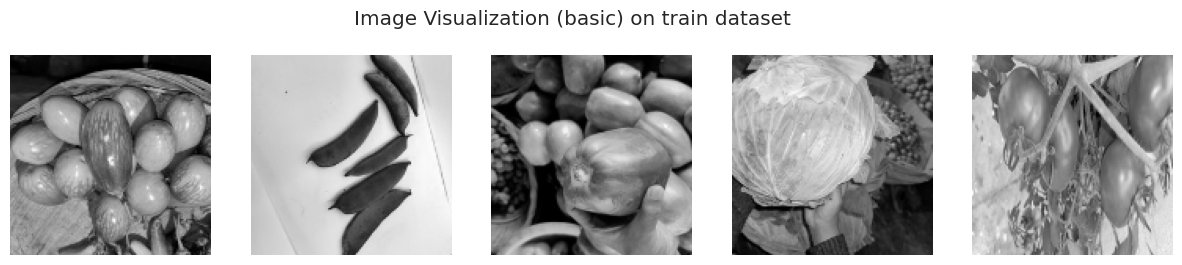

In [33]:
visualisation(train_ds_basic,5,'(basic)','train')

#### Run the model

In [34]:
figures = []
models = models_array()
for i in range(len(models)):
    print(f'Running {model_names[i]}')
    results, fig = evaluator.model_evaluate( train_ds_basic, val_ds_basic , models[i], base_hparams)
    results['Model Name'] = f'{model_names[i]} basic one'
    y_pred = models[i].predict(X_test_big)
    y_pred_classes = np.argmax(y_pred, axis=1)
    kappa = cohen_kappa_score(y_test_big, y_pred_classes)
    print("Cohen’s Kappa Score:", kappa)
    results['Kappa'] = kappa
    overall = pd.concat([overall, pd.DataFrame([results])], ignore_index=True)
    figures.append(fig)
    

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_22 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_22 (ReLU)             (None, 128, 128, 32)      0         
                                                                 
 conv2d_23 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_23 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_23 (ReLU)             (None, 128, 128, 64)    

#### Analysing the Results

In [35]:
overall.iloc[-3:]

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
0,CNN basic one,38,128,0.017855,0.623409,0.996677,0.840000,0.839286,NaN
1,CNN2 basic one,53,128,0.015596,0.062343,0.999668,0.982667,0.985000,NaN
2,VGG_Baseline basic one,63,128,0.169651,0.240200,0.996788,0.974000,0.972500,NaN


#### Analyse the graph

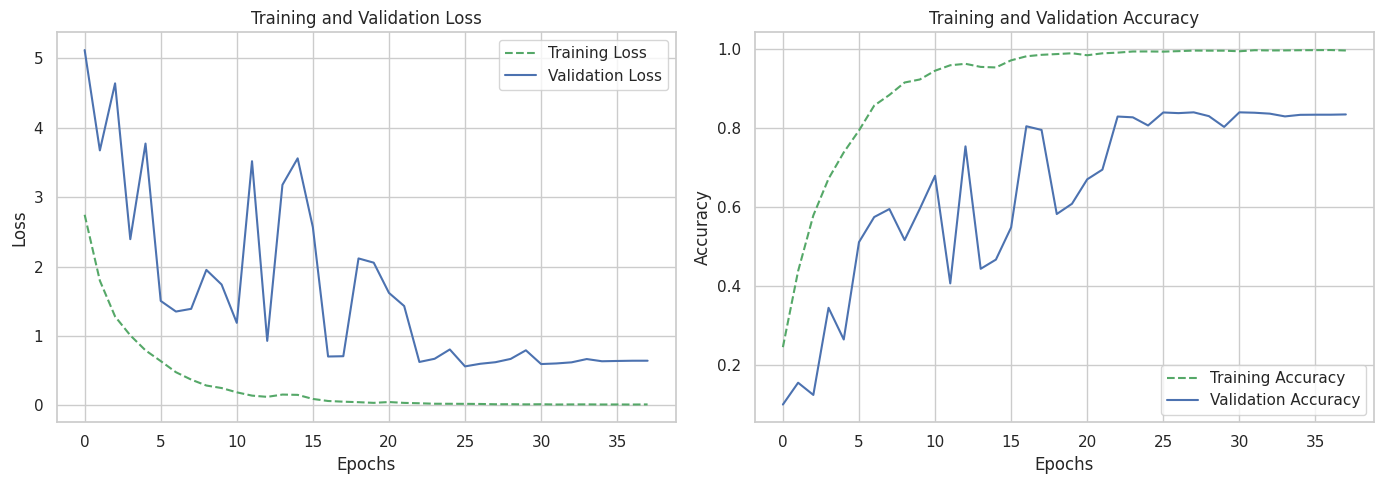

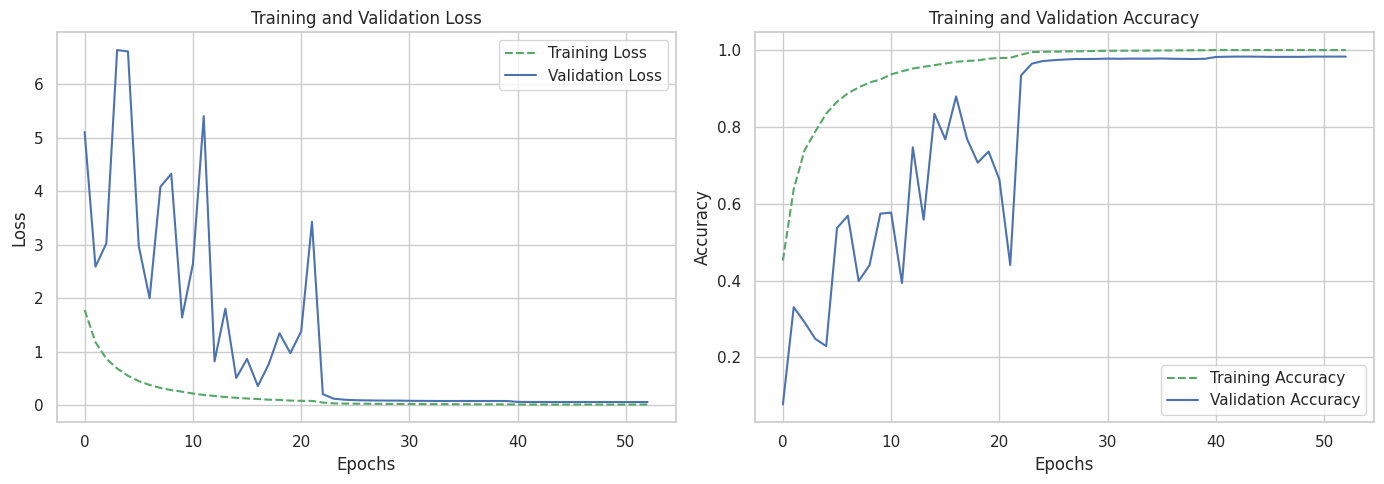

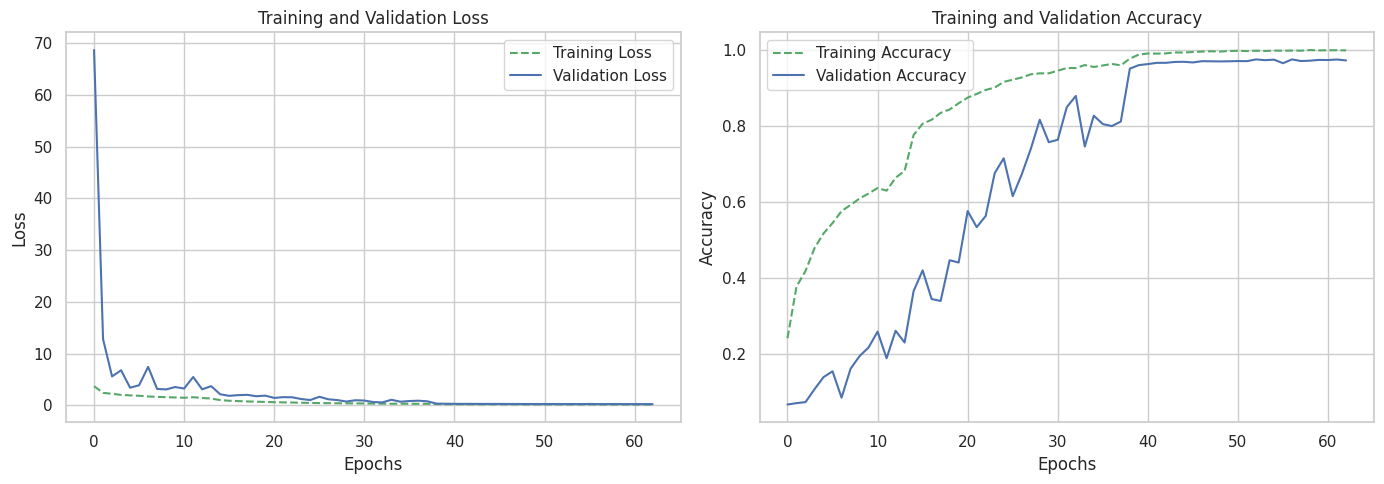

In [36]:
for fig in figures:
    fig()

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

For CNN,
- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a similar accuracy and minor spikes
    
For CNN 2,
- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a similar accuracy and minor spikes

    
For VGG 16,
- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a similar accuracy and minor spikes
</div>

### Data Augmentation 2

- Adjust the color of the iamge
- Change the brightness
- Change the saturation
- Change the hue


In [37]:
def data_augmentation2(image):
    image = tf.image.random_brightness(image, max_delta=0.2) 
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5) 
    image = tf.image.random_hue(image, max_delta=0.2)
    return image

#### Process the train and validation data

In [38]:
train_ds_basic_2 = tf.data.Dataset.from_tensor_slices((X_train_big, y_train_big))
train_ds_basic_2 = train_ds_basic_2.map(preprocess2).batch(128).prefetch(tf.data.AUTOTUNE)

val_ds_basic_2 = tf.data.Dataset.from_tensor_slices((X_val_big, y_val_big))
val_ds_basic_2 = val_ds_basic_2.map(preprocess2).batch(128).prefetch(tf.data.AUTOTUNE)

#### Visualisation of the augmented dataset

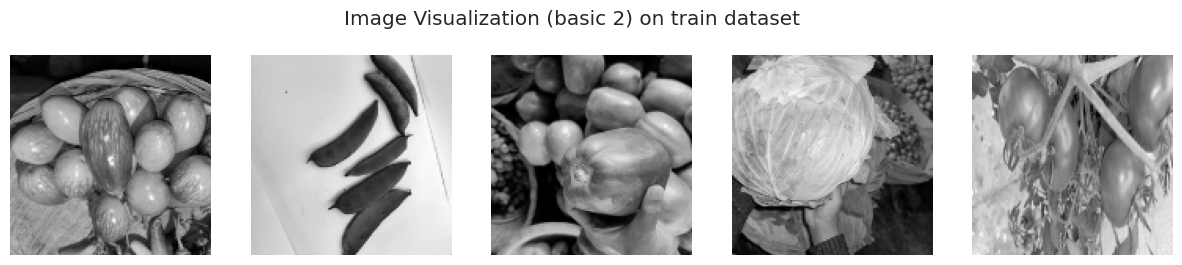

In [39]:
visualisation(train_ds_basic_2,5,'(basic 2)','train')

#### Running the models

In [40]:
figures = []
models = models_array()
for i in range(len(models)):
    print(f'Running {model_names[i]}')
    results, fig = evaluator.model_evaluate( train_ds_basic_2, val_ds_basic_2 , models[i], base_hparams)
    results['Model Name'] = f'{model_names[i]} basic two'
    y_pred = models[i].predict(X_test_big)
    y_pred_classes = np.argmax(y_pred, axis=1)
    kappa = cohen_kappa_score(y_test_big, y_pred_classes)
    print("Cohen’s Kappa Score:", kappa)
    results['Kappa'] = kappa
    overall = pd.concat([overall, pd.DataFrame([results])], ignore_index=True)
    figures.append(fig)
    

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_11 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_11 (ReLU)             (None, 128, 128, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 128, 128, 64)    

#### Analysing the Graph

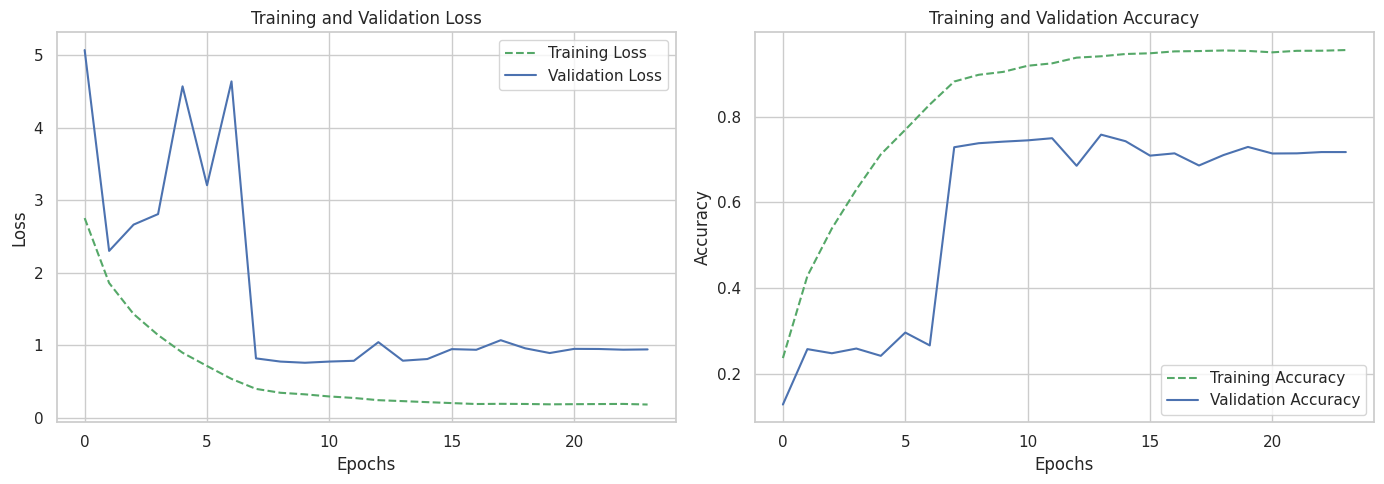

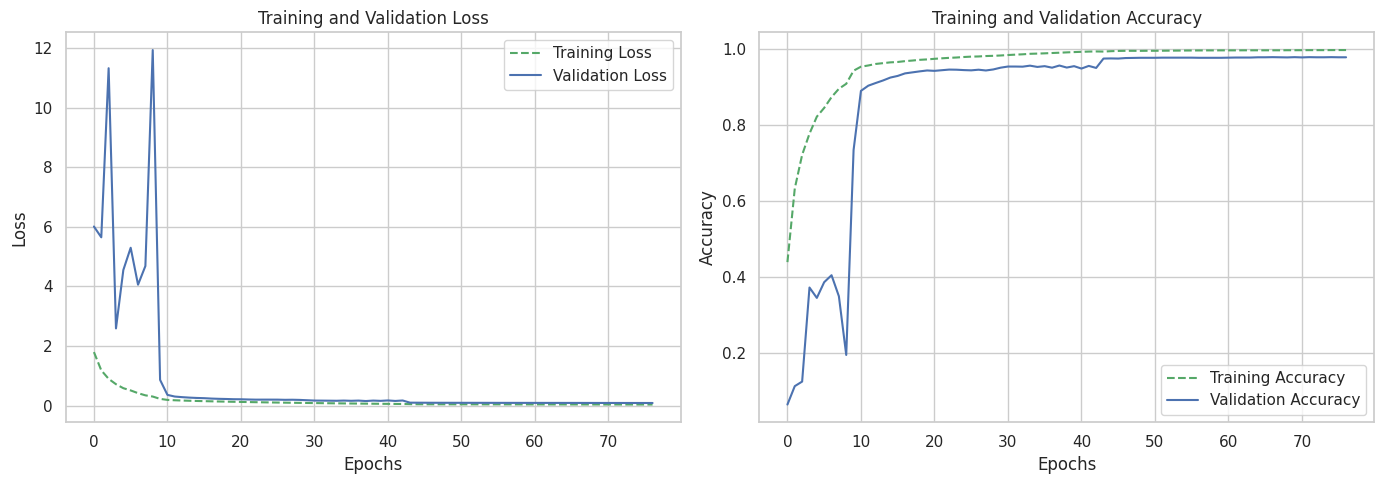

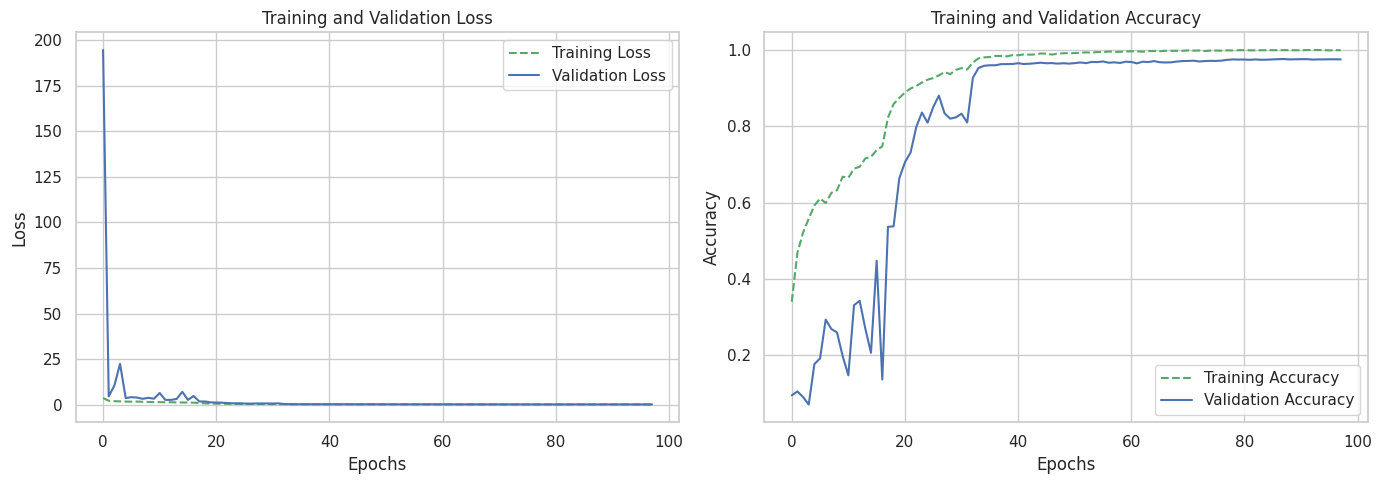

In [41]:
for fig in figures:
    fig()

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

For CNN,
- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a similar accuracy and minor spikes
    
For CNN 2,
- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a similar accuracy and minor spikes

    
For VGG 16,
- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a similar accuracy and minor spikes
</div>

#### Analysing the Results

In [42]:
overall.iloc[-3:]

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
3,CNN basic two,24,128,0.228279,0.786181,0.941294,0.758333,0.745714,NaN
4,CNN2 basic two,77,128,0.038791,0.089882,0.997009,0.979000,0.979286,NaN
5,VGG_Baseline basic two,98,128,0.144072,0.220837,0.999778,0.976333,0.974643,NaN


### CutMix data augmentation

Cutmix Data Augmentation is
- Cut and paste random patches between the training images
- Ground truth labels are mixed in proportion to the area of patches in the images
- It increases localisation ability by making the model to focus on less discriminative parts of the object being classified and hence is also well suited for tasks like object detection

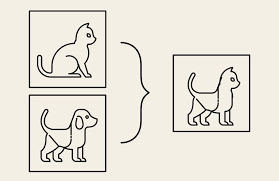

In [28]:
def preprocess_data(image, label):
  image = tf.expand_dims(image, -1)
  return image, label

def sample_beta_distribution(size, concentration_0=300, concentration_1=0.1):
  gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
  gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
  return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
  cut_rat = tf.math.sqrt(1.0 - lambda_value)
  image_wh = (31,31,1)[0]
  cut_wh = image_wh * cut_rat  # rw
  cut_wh = tf.cast(cut_wh, tf.int32)

  cut_x = tf.random.uniform((1,), minval=0, maxval=image_wh, dtype=tf.int32)  # rx
  cut_y = tf.random.uniform((1,), minval=0, maxval=image_wh, dtype=tf.int32)  # ry

  boundaryx1 = tf.clip_by_value(cut_x[0] - cut_wh // 2, 0, image_wh)
  boundaryy1 = tf.clip_by_value(cut_y[0] - cut_wh // 2, 0, image_wh)
  bbx2 = tf.clip_by_value(cut_x[0] + cut_wh // 2, 0, image_wh)
  bby2 = tf.clip_by_value(cut_y[0] + cut_wh // 2, 0, image_wh)

  target_h = bby2 - boundaryy1
  if target_h == 0:
      target_h += 1

  target_w = bbx2 - boundaryx1
  if target_w == 0:
      target_w += 1

  return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
  (image1, label1), (image2, label2) = train_ds_one, train_ds_two
  image_size = (128,128,1)[0]
  alpha = [1]
  beta = [1]
  lambda_value = sample_beta_distribution(1, alpha, beta)
  lambda_value = lambda_value[0][0]
  boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)
  crop2 = tf.image.crop_to_bounding_box(
      image2, boundaryy1, boundaryx1, target_h, target_w
  )
  image2 = tf.image.pad_to_bounding_box(
      crop2, boundaryy1, boundaryx1, image_size, image_size
  )
  crop1 = tf.image.crop_to_bounding_box(
      image1, boundaryy1, boundaryx1, target_h, target_w
  )
  img1 = tf.image.pad_to_bounding_box(
      crop1, boundaryy1, boundaryx1, image_size, image_size
  )

  image1 = image1 - img1
  image = image1 + image2
  lambda_value = 1 - (target_w * target_h) / (image_size * image_size)
  lambda_value = tf.cast(lambda_value, tf.float32)
  label = lambda_value * label1 + (1 - lambda_value) * label2
  return image, label

#### Set up the train and validation data

In [29]:
train_ds_one = tf.data.Dataset.from_tensor_slices((X_train_big, y_train_big)).shuffle(2048).map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_two = tf.data.Dataset.from_tensor_slices((X_train_big, y_train_big)).shuffle(2048).map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

val_ds_cutmix = tf.data.Dataset.from_tensor_slices((X_val_big, y_val_big))
val_ds_cutmix = val_ds_cutmix.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).batch(128).prefetch(tf.data.AUTOTUNE)

train_ds_cutmix = tf.data.Dataset.zip((train_ds_one, train_ds_two))
train_ds_cutmix = (
    train_ds_cutmix.shuffle(1024)
    .map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(128)
    .prefetch(tf.data.AUTOTUNE)
)
train_ds_cutmix
image_batch, label_batch = next(iter(train_ds_cutmix))

#### Visualisation of the augmented dataset

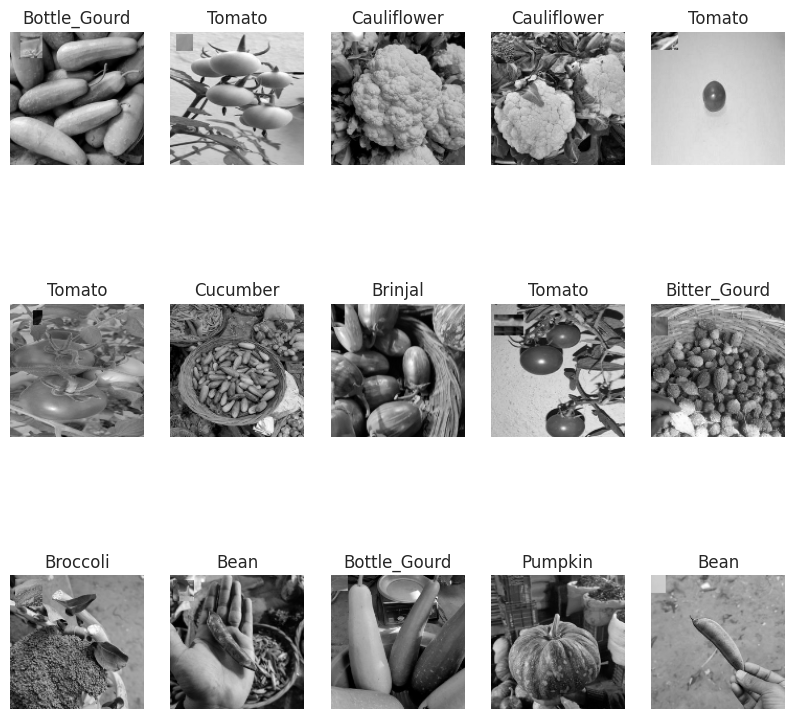

In [45]:
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.title(labels_dict[np.argmax(label_batch[i])])
    plt.imshow(tf.squeeze(image_batch[i]), cmap="gray")
    plt.axis("off")
plt.show()

#### Running the models

In [46]:
models = models_array()
figures_cutmix = []

for i in range(len(models)):
    print(f'Running {model_names[i]}')
    results, fig = evaluator.model_evaluate( train_ds_cutmix, val_ds_cutmix , models[i], base_hparams)
    results['Model Name'] = f'{model_names[i]} cutmix'
    y_pred = models[i].predict(X_test_big)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    kappa = cohen_kappa_score(y_test_big, y_pred_classes)
    print("Cohen’s Kappa Score:", kappa)
    results['Kappa'] = kappa
    overall = pd.concat([overall, pd.DataFrame([results])], ignore_index=True)
    figures_cutmix.append(fig)
    

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_11 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_11 (ReLU)             (None, 128, 128, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 128, 128, 64)    

#### Analysing of Graphs

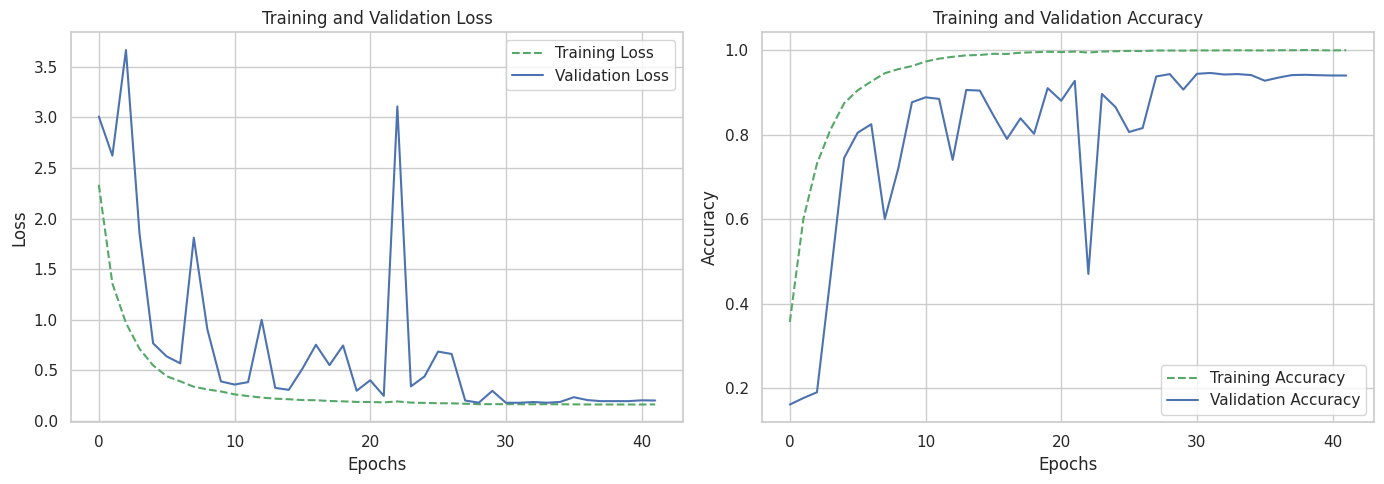

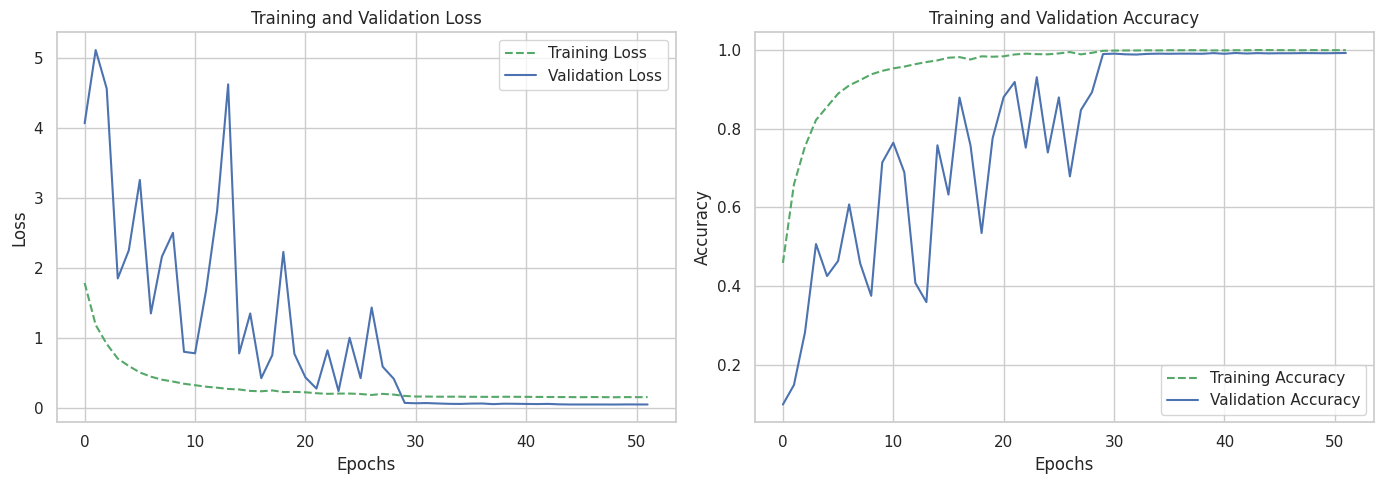

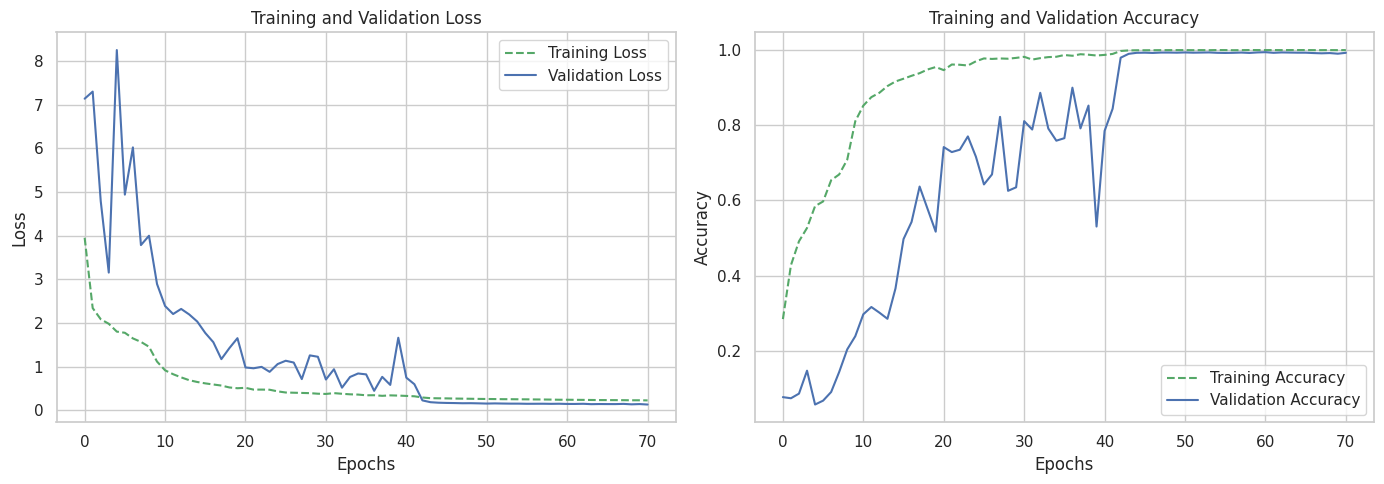

In [47]:
for fig in figures_cutmix:
    fig()

#### Analysing of Results

In [48]:
overall.iloc[-3:]

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
6,CNN cutmix,42,128,0.164451,0.178881,0.998892,0.945667,0.951071,NaN
7,CNN2 cutmix,52,128,0.157783,0.055629,0.999335,0.992333,0.990714,NaN
8,VGG_Baseline cutmix,71,128,0.238155,0.141491,0.999889,0.994333,0.991429,NaN


### CutOut

- Cutout image augmentation is to randomly remove a square region of pixels in an input image during training
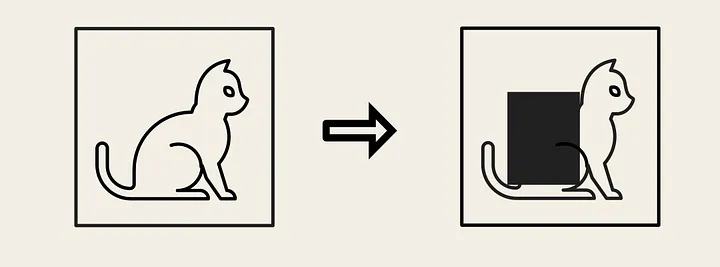

In [49]:
def cutout(image, n_holes, length):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    mask = tf.ones((height, width), dtype=tf.float32)

    for _ in range(n_holes):
        y = tf.random.uniform([], 0, height, dtype=tf.int32)
        x = tf.random.uniform([], 0, width, dtype=tf.int32)

        y1 = tf.cast(tf.clip_by_value(y - length // 2, 0, height), tf.int32)
        y2 = tf.cast(tf.clip_by_value(y + length // 2, 0, height), tf.int32)
        x1 = tf.cast(tf.clip_by_value(x - length // 2, 0, width), tf.int32)
        x2 = tf.cast(tf.clip_by_value(x + length // 2, 0, width), tf.int32)

        y_mask = (tf.range(height)[:, None] >= y1) & (tf.range(height)[:, None] < y2)
        x_mask = (tf.range(width)[None, :] >= x1) & (tf.range(width)[None, :] < x2)
        cutout_mask = y_mask & x_mask

        mask = tf.where(cutout_mask, tf.zeros_like(mask), mask)

    mask = tf.expand_dims(mask, -1)  # Expanding to 3D to match image dimensions
    mask = tf.tile(mask, [1, 1, tf.shape(image)[-1]])  # Adjusting channels to match the image

    return image * mask

#### Set up the train and validation data

In [50]:
train_ds_one = tf.data.Dataset.from_tensor_slices((X_train_big, y_train_big)).shuffle(2048).map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_two = tf.data.Dataset.from_tensor_slices((X_train_big, y_train_big)).shuffle(2048).map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

val_ds_cutout = tf.data.Dataset.from_tensor_slices((X_val_big, y_val_big))
val_ds_cutout = val_ds_cutout.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_cutout = val_ds_cutout.map(lambda x, y: (cutout(x, n_holes=1, length=16), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds_cutout = val_ds_cutout.batch(128).prefetch(tf.data.AUTOTUNE)

train_ds_cutout = train_ds_one.map(lambda x, y: (cutout(x, n_holes=1, length=16), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds_cutout = train_ds_cutout.batch(128).prefetch(tf.data.AUTOTUNE)

image_batch, label_batch = next(iter(train_ds_cutout))

#### Visualisation of the augmented dataset

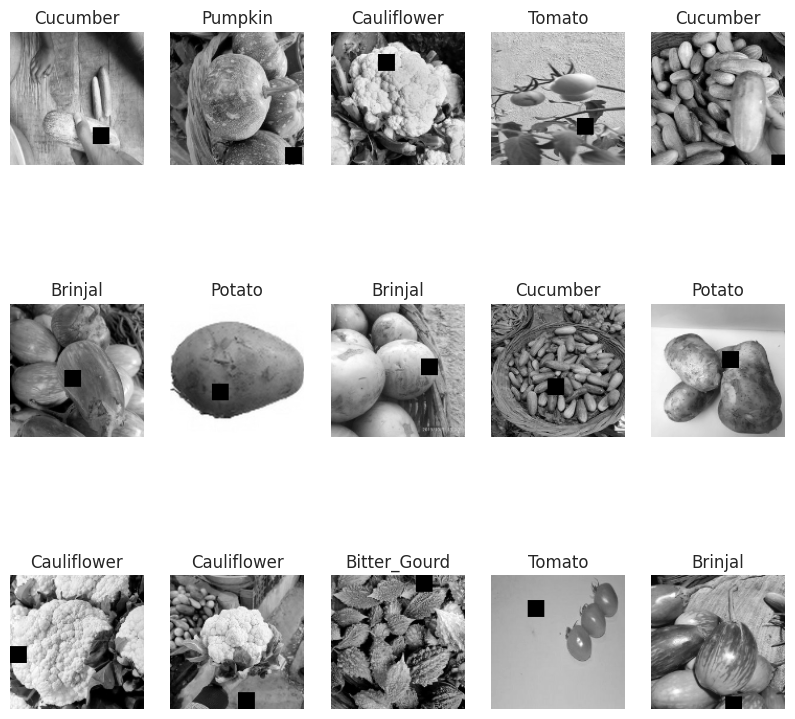

In [51]:
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.title(labels_dict[np.argmax(label_batch[i])])
    plt.imshow(tf.squeeze(image_batch[i]), cmap="gray")
    plt.axis("off")
plt.show()

#### Running the models

In [52]:
models = models_array()
figures_cutout = []

for i in range(len(models)):
    print(f'Running {model_names[i]}')
    results, fig = evaluator.model_evaluate( train_ds_cutout, val_ds_cutout , models[i], base_hparams)
    results['Model Name'] = f'{model_names[i]} cutout'
    y_pred = models[i].predict(X_test_big)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    kappa = cohen_kappa_score(y_test_big, y_pred_classes)
    print("Cohen’s Kappa Score:", kappa)
    results['Kappa'] = kappa
    overall = pd.concat([overall, pd.DataFrame([results])], ignore_index=True)
    figures_cutout.append(fig)
    

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_11 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_11 (ReLU)             (None, 128, 128, 32)      0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 128, 128, 64)    

#### Analysing of Graphs

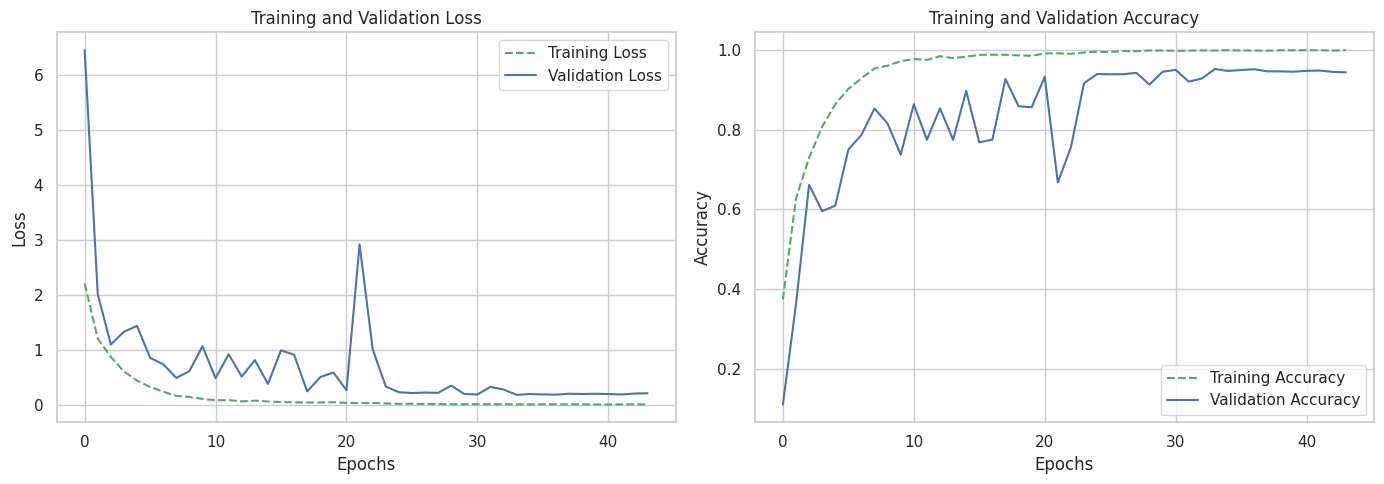

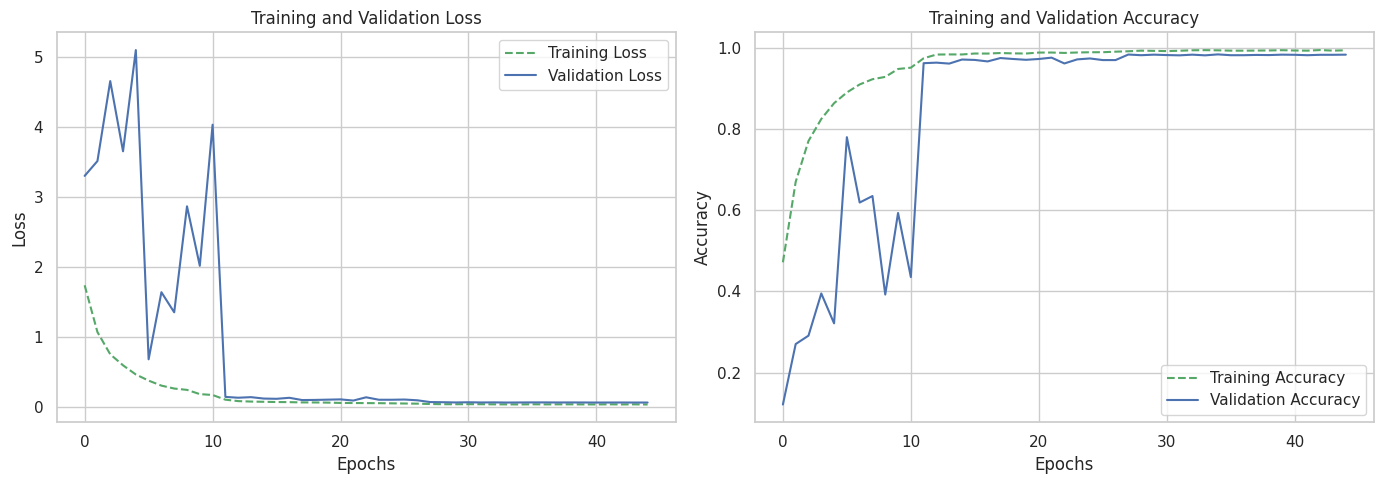

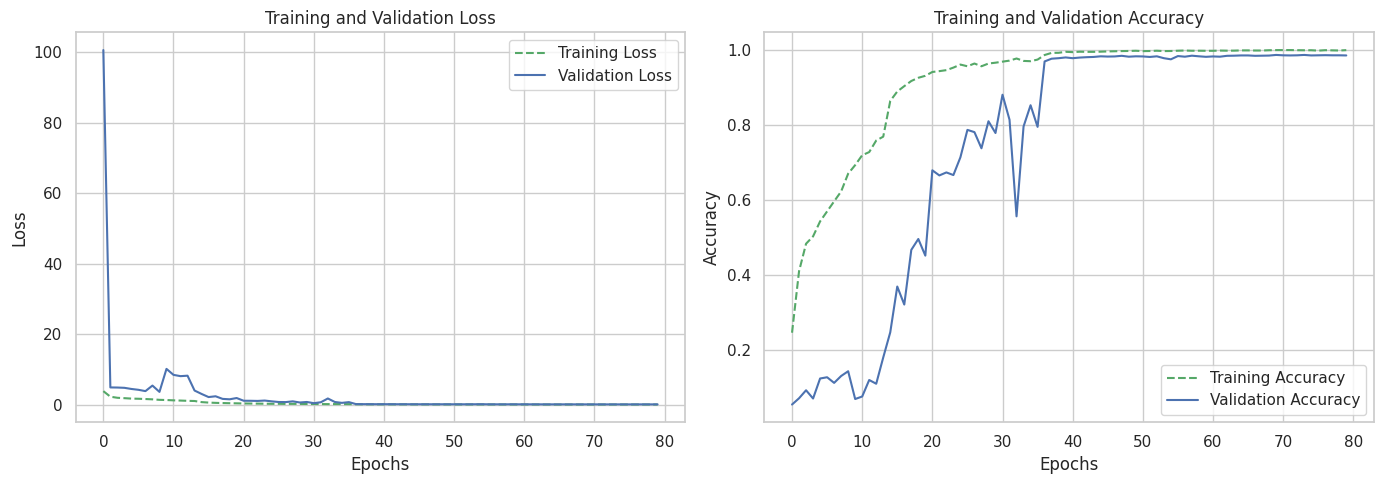

In [53]:
for fig in figures_cutout:
    fig()

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

For CNN,
- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a similar accuracy and minor spikes
    
For CNN 2,
- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a similar accuracy and minor spikes

    
For VGG 16,
- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a similar accuracy and minor spikes
</div>

#### Analysing of Result

In [54]:
overall.iloc[-3:]

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
9,CNN cutout,44,128,0.009736,0.181197,0.997674,0.951667,0.956429,NaN
10,CNN2 cutout,45,128,0.042143,0.069994,0.994019,0.984000,0.981786,NaN
11,VGG_Baseline cutout,80,128,0.129479,0.174903,0.999225,0.986333,0.983214,NaN


<a class="anchor" id="1"></a>
## <font color='#71a1e3'> __Model Improvement - Add Regularisation__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">

- **Does Regularisation helps ?**

Goal: 
- Try and reduce the adjusted loss function and prevent overfitting or underfitting
- Improvement of model

### CNN Baseline Updated

- Added l2 regularisation

In [55]:
def cnn_lr(optimizer='adam', name='CNN_Baseline_LR', l2_reg=0.01):
    model = Sequential(name=name)

    # Input layer
    model.add(Input(shape=(128, 128, 1)))
    
   # First Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
   # Second Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
   # Third Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    # Dense Block with L2 
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(15, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model
cnn_lr = cnn_lr()

Model: "CNN_Baseline_LR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)  

#### Running the Model

In [56]:
results_cnn_lr, fig_cnn_lr = evaluator.model_evaluate( train_ds, val_ds , cnn_lr, base_hparams)

Epoch 1/100
71/71 [==============================] - 5s 53ms/step - loss: 14.9827 - accuracy: 0.3425 - val_loss: 14.0496 - val_accuracy: 0.1783 - lr: 0.0010
Epoch 2/100
71/71 [==============================] - 3s 44ms/step - loss: 8.7951 - accuracy: 0.5913 - val_loss: 7.7349 - val_accuracy: 0.3440 - lr: 0.0010
Epoch 3/100
71/71 [==============================] - 3s 44ms/step - loss: 5.9010 - accuracy: 0.6977 - val_loss: 7.0035 - val_accuracy: 0.2513 - lr: 0.0010
Epoch 4/100
71/71 [==============================] - 3s 44ms/step - loss: 4.8807 - accuracy: 0.7591 - val_loss: 5.6895 - val_accuracy: 0.4397 - lr: 0.0010
Epoch 5/100
71/71 [==============================] - 3s 44ms/step - loss: 4.2563 - accuracy: 0.7941 - val_loss: 5.3168 - val_accuracy: 0.5137 - lr: 0.0010
Epoch 6/100
71/71 [==============================] - 3s 44ms/step - loss: 4.0950 - accuracy: 0.8250 - val_loss: 4.9939 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 7/100
71/71 [==============================] - 3s 44ms/step - 

#### Analysing the graph

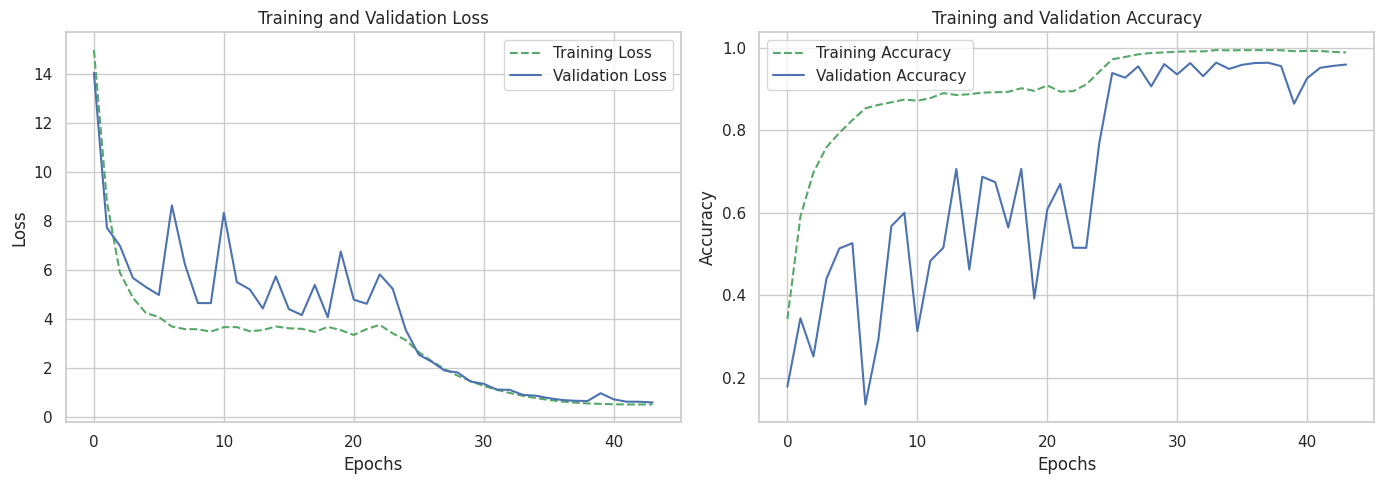

In [57]:
fig_cnn_lr()

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- Training and Validation loss
    - For the training loss, it starts relatively high and drops quickly and continues to decrease steadily as the epochs increases
    - For the validation loss, similar patterns occur with the epoch increasing with really minor spikes and it is the same as valdiation loss

- Training and Validation accuracy
    - For the training accuracy, it increases sharply at the beginning and continues to increase gradually, indicates effective lerarning
    - For the validation accuracy, similar pattern is seen but with a higher accuracy than train and initial spikes
</div>

In [58]:
pd.Series(results_cnn_lr)

Model Name    CNN_Baseline_LR
Epochs                     44
Batch Size                128
Train Loss           0.881994
Test Loss            0.921476
Train Acc            0.995126
Test Acc             0.964667
dtype: object

#### Compare the difference

In [29]:
# pd.Series(results_cnn)

#### Evaluation on test set

- This is to check for overfitting
- And also how the model performs with respect to each classes

In [60]:
cls_df_cnn_lr= evaluation_test(cnn_lr, X_test_big, y_test_big, labels_dict)
cls_df_cnn_lr

94/94 [==============================] - 1s 4ms/step
Accuracy: 0.967


,precision,recall,f1-score,support
Potato,0.926108,0.940,0.933002,200.000
Papaya,0.915094,0.970,0.941748,200.000
Carrot,0.968421,0.920,0.943590,200.000
Brinjal,0.950739,0.965,0.957816,200.000
Cabbage,0.929577,0.990,0.958838,200.000
Capsicum,0.942584,0.985,0.963325,200.000
Radish,0.989529,0.945,0.966752,200.000
accuracy,0.967000,0.967,0.967000,0.967
macro avg,0.967798,0.967,0.967094,3000.000
weighted avg,0.967798,0.967,0.967094,3000.000


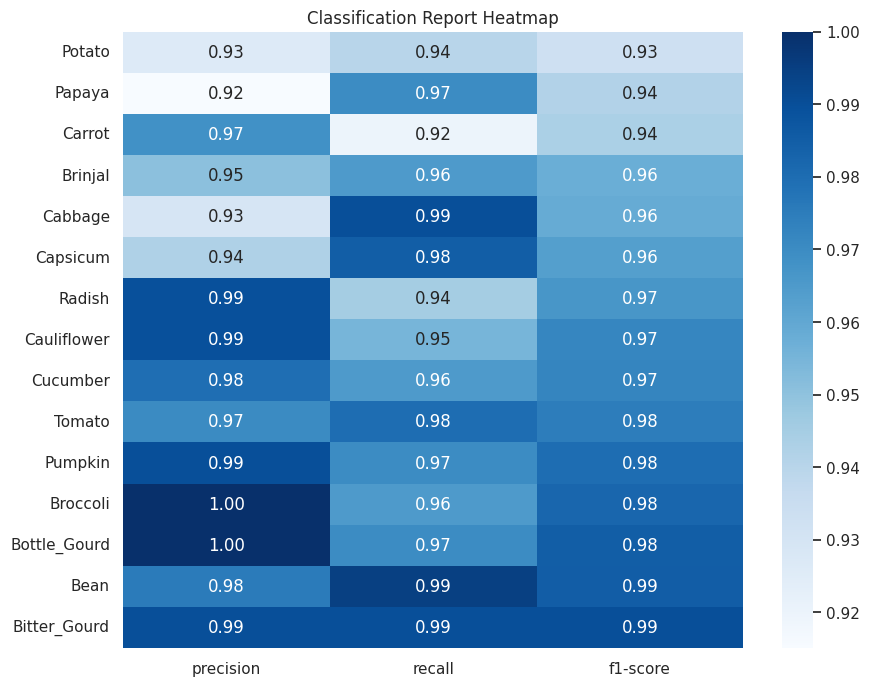

In [61]:
plot_classification_heatmap(cls_df_cnn_lr)

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the heatmap and the evaluation score, we can see that the model is 06.7% and similar to train accuracy
- In addition the mdoel is best at predicting Bottle Gourd and worst at Potato in terms of f1 score
</div>

#### Cohen Kappa Coefficient

In [62]:
y_pred = cnn_lr.predict(X_test_big)
y_pred_classes = np.argmax(y_pred, axis=1)
kappa_cnn_lr = cohen_kappa_score(y_test_big, y_pred_classes)
print("Cohen’s Kappa Score:", kappa_cnn_lr)

94/94 [==============================] - 0s 4ms/step
Cohen’s Kappa Score: 0.9646428571428571


<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the Cophen Kappa Coefficient, we can see that the model is very reliable
</div>

In [63]:
results_cnn_lr['Model Name'] = 'CNN_Reg'
results_cnn_lr['Kappa'] = kappa_cnn_lr
overall = pd.concat([overall, pd.DataFrame([results_cnn_lr])], ignore_index=True)
overall

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
0,CNN basic one,38,128,0.017855,0.623409,0.996677,0.840000,0.839286,NaN
1,CNN2 basic one,53,128,0.015596,0.062343,0.999668,0.982667,0.985000,NaN
2,VGG_Baseline basic one,63,128,0.169651,0.240200,0.996788,0.974000,0.972500,NaN
3,CNN basic two,24,128,0.228279,0.786181,0.941294,0.758333,0.745714,NaN
4,CNN2 basic two,77,128,0.038791,0.089882,0.997009,0.979000,0.979286,NaN
5,VGG_Baseline basic two,98,128,0.144072,0.220837,0.999778,0.976333,0.974643,NaN
6,CNN cutmix,42,128,0.164451,0.178881,0.998892,0.945667,0.951071,NaN
7,CNN2 cutmix,52,128,0.157783,0.055629,0.999335,0.992333,0.990714,NaN
8,VGG_Baseline cutmix,71,128,0.238155,0.141491,0.999889,0.994333,0.991429,NaN
9,CNN cutout,44,128,0.009736,0.181197,0.997674,0.951667,0.956429,NaN


### CNN2 Baseline Updated

- Added l2 regularisation

In [64]:
def CNN2_Reg(name='CNN2_Baseline', l2_reg=0.01, dropout_rate=0.5):
    filters_list = [32, 64, 128, 128, 128, 128]
    model = Sequential(name=name)

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(128, 128, 1), kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Dropout(dropout_rate))

    for filters in filters_list[2:]:
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(ReLU())

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(15, activation='softmax')) 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
cnn2_reg = CNN2_Reg()

Model: "CNN2_Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 128, 128, 64)    

#### Running the model

In [72]:
results_cnn2_lr, fig_cnn2_lr = evaluator.model_evaluate( train_ds_cutmix, val_ds_cutmix , cnn2_reg, base_hparams)

Epoch 1/100
71/71 [==============================] - 19s 262ms/step - loss: 0.4528 - accuracy: 0.9846 - val_loss: 0.3354 - val_accuracy: 0.9693 - lr: 1.0000e-07
Epoch 2/100
71/71 [==============================] - 19s 261ms/step - loss: 0.4495 - accuracy: 0.9870 - val_loss: 0.3407 - val_accuracy: 0.9663 - lr: 1.0000e-07
Epoch 3/100
71/71 [==============================] - 19s 261ms/step - loss: 0.4488 - accuracy: 0.9870 - val_loss: 0.3448 - val_accuracy: 0.9640 - lr: 1.0000e-07
Epoch 4/100
71/71 [==============================] - 19s 262ms/step - loss: 0.4494 - accuracy: 0.9870 - val_loss: 0.3489 - val_accuracy: 0.9623 - lr: 1.0000e-07
Epoch 5/100
71/71 [==============================] - 19s 261ms/step - loss: 0.4510 - accuracy: 0.9873 - val_loss: 0.3508 - val_accuracy: 0.9600 - lr: 1.0000e-07
Epoch 6/100
71/71 [==============================] - 19s 261ms/step - loss: 0.4502 - accuracy: 0.9872 - val_loss: 0.3522 - val_accuracy: 0.9590 - lr: 1.0000e-07
Epoch 7/100
71/71 [===============

In [66]:
pd.Series(results_cnn2_lr)

Model Name    CNN2_Baseline
Epochs                   78
Batch Size              128
Train Loss         0.307886
Test Loss          0.334669
Train Acc          0.985711
Test Acc           0.970333
dtype: object

#### Comparing the difference

In [ ]:
# pd.Series(results_cnn2)

#### Analysing the graph

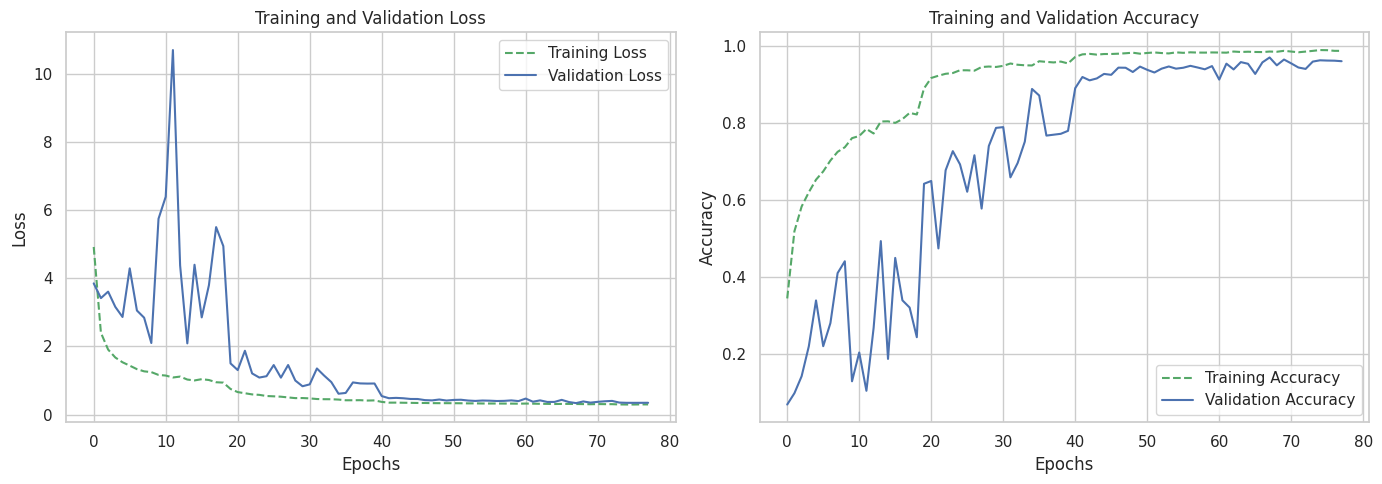

In [67]:
fig_cnn2_lr()

#### Evaluation on test set

- This is to check for overfitting
- And also how the model performs with respect to each classes

In [68]:
cls_df_cnn2lr= evaluation_test(cnn2_reg, X_test_big, y_test_big, labels_dict)
cls_df_cnn2lr

94/94 [==============================] - 2s 16ms/step
Accuracy: 0.9693333333333334


,precision,recall,f1-score,support
Cauliflower,0.903670,0.985000,0.942584,200.000000
Potato,0.949749,0.945000,0.947368,200.000000
Tomato,0.904977,1.000000,0.950119,200.000000
Radish,0.994536,0.910000,0.950392,200.000000
Papaya,0.924883,0.985000,0.953995,200.000000
Pumpkin,0.960591,0.975000,0.967742,200.000000
accuracy,0.969333,0.969333,0.969333,0.969333
weighted avg,0.970798,0.969333,0.969509,3000.000000
macro avg,0.970798,0.969333,0.969509,3000.000000
Cucumber,0.989637,0.955000,0.972010,200.000000


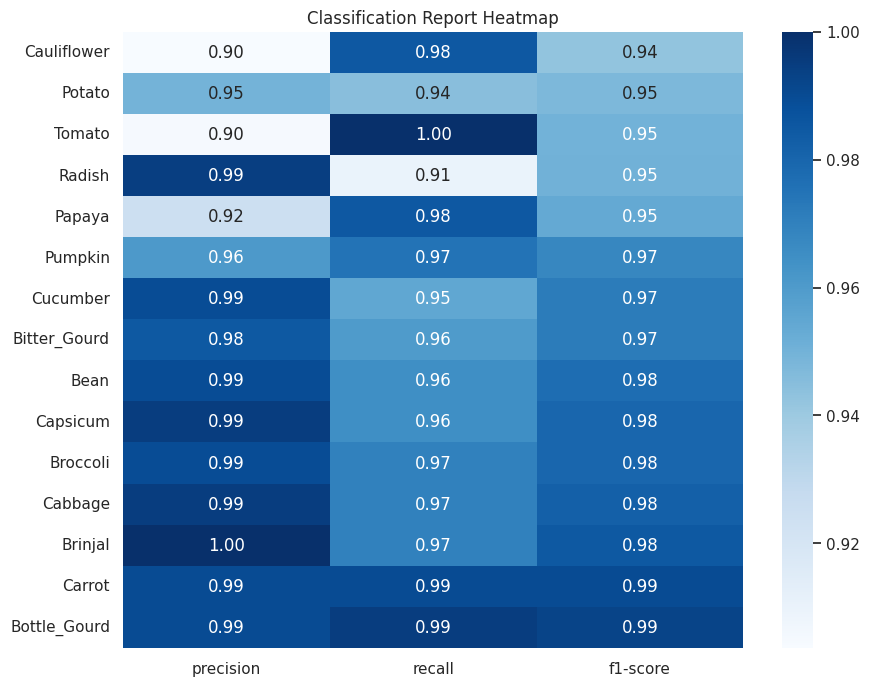

In [69]:
plot_classification_heatmap(cls_df_cnn2lr)

<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- From the heatmap and the evaluation score, we can see that the model is at 97.7% showing no overfitting
- In addition, the model is best at prediction Bottle Gourd and worst at Brinjal in terms of f1 score
</div>

#### Cohen Kappa Coefficient

In [70]:
y_pred = cnn2_reg.predict(X_test_big)
y_pred_classes = np.argmax(y_pred, axis=1)
kappa_cnn2_reg = cohen_kappa_score(y_test_big, y_pred_classes)
print("Cohen’s Kappa Score:", kappa_cnn2_reg)

94/94 [==============================] - 2s 16ms/step
Cohen’s Kappa Score: 0.9671428571428572


#### Adding Scores to Dataframe

In [71]:
results_cnn2_lr['Model Name'] = 'CNN2_Reg'
results_cnn2_lr['Kappa'] = kappa_cnn2_reg
overall = pd.concat([overall, pd.DataFrame([results_cnn2_lr])], ignore_index=True)
overall

,Model Name,Epochs,Batch Size,Train Loss,Test Loss,Train Acc,Test Acc,Kappa,Comments
0,CNN basic one,38,128,0.017855,0.623409,0.996677,0.840000,0.839286,NaN
1,CNN2 basic one,53,128,0.015596,0.062343,0.999668,0.982667,0.985000,NaN
2,VGG_Baseline basic one,63,128,0.169651,0.240200,0.996788,0.974000,0.972500,NaN
3,CNN basic two,24,128,0.228279,0.786181,0.941294,0.758333,0.745714,NaN
4,CNN2 basic two,77,128,0.038791,0.089882,0.997009,0.979000,0.979286,NaN
5,VGG_Baseline basic two,98,128,0.144072,0.220837,0.999778,0.976333,0.974643,NaN
6,CNN cutmix,42,128,0.164451,0.178881,0.998892,0.945667,0.951071,NaN
7,CNN2 cutmix,52,128,0.157783,0.055629,0.999335,0.992333,0.990714,NaN
8,VGG_Baseline cutmix,71,128,0.238155,0.141491,0.999889,0.994333,0.991429,NaN
9,CNN cutout,44,128,0.009736,0.181197,0.997674,0.951667,0.956429,NaN


<div class="alert alert-block" style="background-color:#a7c6d6; padding: 10px; border: 3px solid lightblue; border-radius: 5px; color:black">
<u><b><i>Things Observed</i></b></u>
<ul>

- Overall, the best models are cnn cutmix and vgg cutmix
</div>

<a class="anchor" id="2"></a>
## <font color='#71a1e3'>__Model Improvement - Learning Rate__</font>
<hr style="height:1.5px;border-width:0;background-color: #4c8c77">


### Cosine Annealing 


- Type of learning rate schedule that has the effect of starting with a large learning rate that is relatively rapidly decreased to a minimum value before being increased rapidly again
- The resetting of the learning rate acts like a simulated restart of the learning process and the re-use of good weights as the starting point of the restart is referred to as a "warm restart" in contrast to a "cold restart" where a new set of small random numbers may be used as a starting point

Data used will be the original dataset

In [31]:
def lr_warmup_cosine_decay(global_step=10, warmup_steps=100, hold=0, total_steps=1000, start_lr=0.01, target_lr=1e-3):
    if total_steps <= warmup_steps:
        raise ValueError("total_steps must be greater than warmup_steps.")
    global_step = float(global_step)
    warmup_steps = float(warmup_steps)
    hold = float(hold)
    total_steps = float(total_steps)
    start_lr = float(start_lr)
    target_lr = float(target_lr)

    if global_step < warmup_steps:
        warmup_lr = start_lr + (target_lr - start_lr) * (global_step / warmup_steps)
        return warmup_lr
    elif global_step <= warmup_steps + hold:
        return target_lr
    else:
        decayed = 0.5 * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / (total_steps - warmup_steps - hold)))
        decayed_lr = target_lr + (start_lr - target_lr) * decayed
        return decayed_lr



### CNN Model with special LR

In [34]:
def CNN1_reg(optimizer=None, name='CNN_secial_R'):
    model = Sequential(name=name)

    # Input layer
    model.add(Input(shape=(128, 128, 1)))

    # First Convolutional Block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second Convolutional Block
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third Convolutional Block
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())

    # Dense Block
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Dense Block
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(15, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model
cnn_reg = CNN1_reg(optimizer = optimizer) 

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_warmup_cosine_decay)

initial_lr = 0.001  
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

results_cnn_clr, fig_cnn_clr = evaluator.model_evaluate( train_ds_cutmix, val_ds_cutmix , cnn_reg , base_hparams,callbacks=[EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5), lr_schedule])

Model: "CNN_secial_R"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)     

#### Analyse the graph

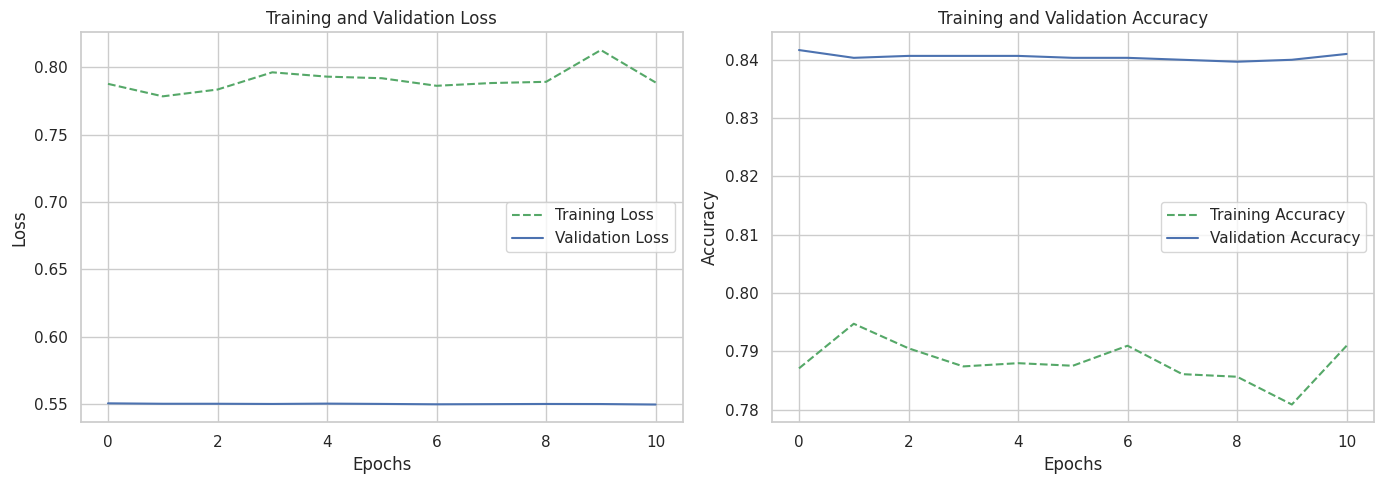

In [34]:
fig_cnn_clr()

#### Analyse the results

In [35]:
pd.Series(results_cnn_clr)

Model Name    CNN_secial_R
Epochs                  53
Batch Size             128
Train Loss        0.153164
Test Loss          0.19572
Train Acc         0.999225
Test Acc          0.944667
dtype: object

### CNN 2 Model with special LR

In [32]:
def CNN2_Reg(name='CNN2_Reg',  dropout_rate=0.5, optimizer = None):
    filters_list = [32, 64, 128, 128, 128, 128]
    model = Sequential(name=name)

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Dropout(dropout_rate))

    for filters in filters_list[2:]:
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(15, activation='softmax')) 
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
cnn2_reg = CNN2_Reg(optimizer = optimizer) 

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_warmup_cosine_decay)

initial_lr = 0.001  
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

results_cnn2_clr, fig_cnn2_clr = evaluator.model_evaluate( train_ds_cutmix, val_ds_cutmix , cnn2_reg , base_hparams,callbacks=[EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5), lr_schedule])

Model: "CNN2_Reg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_17 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_17 (ReLU)             (None, 128, 128, 32)      0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_18 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_18 (ReLU)             (None, 128, 128, 64)      0  

#### Analyse the graph

In [ ]:
fig_cnn2_clr()

#### Analyse the results

In [ ]:
pd.Series(results_cnn2_clr)

In [ ]:
import pandas as pd

data = {
    'Model Name': [
        'CNN basic one', 'CNN2 basic one', 'VGG_Baseline basic one', 'CNN basic two',
        'CNN2 basic two', 'VGG_Baseline basic two', 'CNN cutmix', 'CNN2 cutmix',
        'VGG_Baseline cutmix', 'CNN cutout', 'CNN2 cutout', 'VGG_Baseline cutout',
        'CNN_Reg', 'CNN2_Reg'
    ],
    'Epochs': [38, 53, 63, 24, 77, 98, 42, 52, 71, 44, 45, 80, 44, 78],
    'Batch Size': [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128],
    'Train Loss': [0.017855, 0.015596, 0.169651, 0.228279, 0.038791, 0.144072, 0.164451,
                   0.157783, 0.238155, 0.009736, 0.042143, 0.129479, 0.881994, 0.307886],
    'Test Loss': [0.623409, 0.062343, 0.240200, 0.786181, 0.089882, 0.220837, 0.178881,
                  0.055629, 0.141491, 0.181197, 0.069994, 0.174903, 0.921476, 0.334669],
    'Train Acc': [0.996677, 0.999668, 0.996788, 0.941294, 0.997009, 0.999778, 0.998892,
                  0.999335, 0.999889, 0.997674, 0.994019, 0.999225, 0.995126, 0.985711],
    'Test Acc': [0.840000, 0.982667, 0.974000, 0.758333, 0.979000, 0.976333, 0.945667,
                 0.992333, 0.994333, 0.951667, 0.984000, 0.986333, 0.964667, 0.970333],
    'Kappa': [0.839286, 0.985000, 0.972500, 0.745714, 0.979286, 0.974643, 0.951071,
              0.990714, 0.991429, 0.956429, 0.981786, 0.983214, 0.964643, 0.967143],
    'Comments': [None, None, None, None, None, None, None, None, None, None, None, None, 'Na', 'Na']
}

overall = pd.DataFrame(overall)
print(overall)